<a href="https://colab.research.google.com/github/edenspec2/labcode_updated/blob/main/Copy_of_Catalysis_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/edenspec2/labcode_updated.git
%cd labcode_updated


Cloning into 'labcode_updated'...
remote: Enumerating objects: 3972, done.
remote: Counting objects: 100% (540/540), done.
remote: Compressing objects: 100% (380/380), done.
remote: Total 3972 (delta 265), reused 385 (delta 151), pack-reused 3432 (from 1)
Receiving objects: 100% (3972/3972), 342.22 MiB | 20.95 MiB/s, done.
Resolving deltas: 100% (1755/1755), done.
Updating files: 100% (531/531), done.
/content/labcode_updated


In [ ]:
%%python install_packages.py


🔎 Environment Info
Python executable : /usr/bin/python3
Python version    : 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Working directory : /content/labcode_updated
PATH              : /opt/bin ...

Checking required packages...

pandas heyy

Attempting to install 'pandas' ...
✅ Installed successfully: pandas
❌ Failed to import pandas even after installation. Error: No module named 'pandas==2'
rdkit heyy

Attempting to install 'rdkit' ...
✅ Installed successfully: rdkit
❌ Failed to import rdkit even after installation. Error: No module named 'rdkit==2023'
python-igraph heyy
✔ Imported successfully: python-igraph (import as 'igraph')
XlsxWriter heyy

Attempting to install 'XlsxWriter' ...
✅ Installed successfully: XlsxWriter
❌ Failed to import XlsxWriter even after installation. Error: No module named 'XlsxWriter==3'
ipywidgets heyy

Attempting to install 'ipywidgets' ...
✅ Installed successfully: ipywidgets
❌ Failed to import ipywidgets even after installation. Error: No module

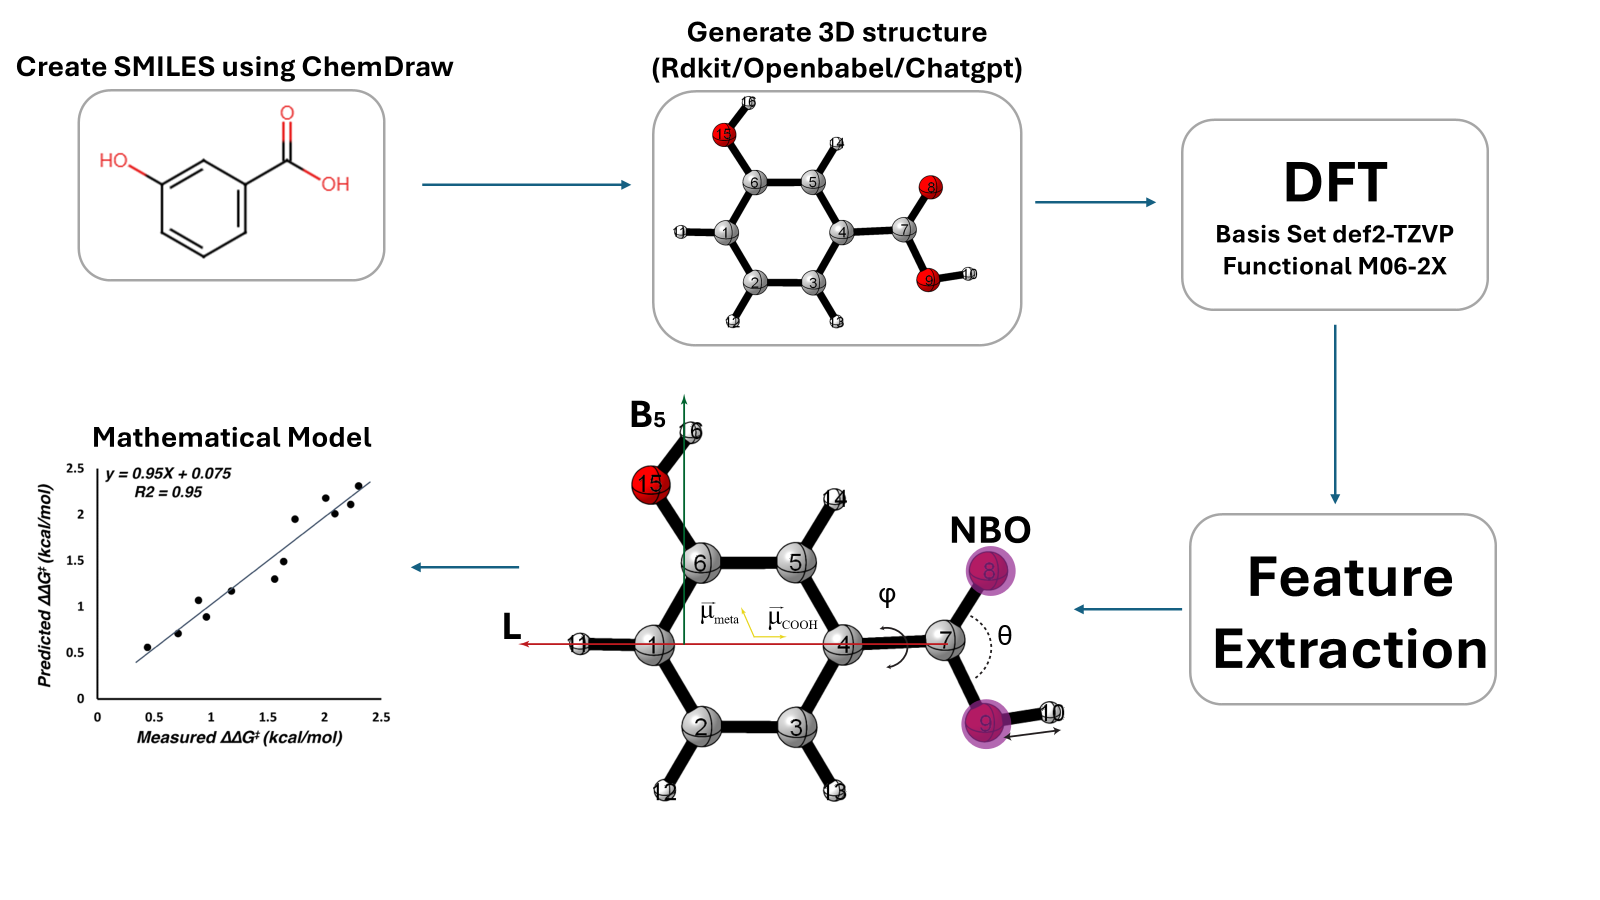

In [ ]:
# ===imports===
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
import importlib
import numpy as np
import pandas as pd
from pathlib import Path
# === Setup ===
# Might need to change to main directory of MolFeatures - r'/your/path/to/MolFeatures'
ROOT_DIR = r'/content/labcode_updated/MolFeatures'
print(f"Setting ROOT_DIR to: {ROOT_DIR}")
sys.path.append(ROOT_DIR)
sys.path.append(os.path.join(ROOT_DIR, 'M3_modeler'))
sys.path.append(os.path.join(ROOT_DIR, 'M2_data_extractor'))
sys.path.append(os.path.join(ROOT_DIR, 'utils'))
os.chdir(ROOT_DIR)  # Set working directory

# === Clear old module caches ===
for module in ['data_extractor', 'feather_extractor', 'gaussian_handler', 'help_functions', 'modeling', 'plot']:
    sys.modules.pop(module, None)

# === Safe Imports ===
try:
    from data_extractor import Molecules, extract_connectivity
    from morfeus_sterics import morfeus_results_to_df
    from feather_extractor import logs_to_feather
    import gaussian_handler
    from gaussian_handler import feather_file_handler
    from help_functions import dict_to_horizontal_df, get_df_from_file, pick_samples_to_remove_for_distribution
    import help_functions
    import visualize
    from modeling import (
        ClassificationModel,
        LinearRegressionModel,
        fit_and_evaluate_single_combination_regression,
        fit_and_evaluate_single_combination_classification

    )
    import plot

except ModuleNotFoundError as e:
    print(f"Module import failed: {e} \nPlease ensure all required modules are installed and available in the path specified on the right hand corner of the notebook.")
# === Config ===
pd.set_option('display.max_columns', None)
examples_path=ROOT_DIR + '/Getting_started_with_examples'
try:
    os.chdir(examples_path)  # Ensure working directory is examples_path
except :
    print(f"Could not change directory to {examples_path}. Please ensure the path exists.")
    print(f"Current working directory: {os.getcwd()}")
    pass


Setting ROOT_DIR to: /content/labcode_updated/MolFeatures


**Modeling Case 1 - Heck Arylation using Benzoic Acid Surrogate **

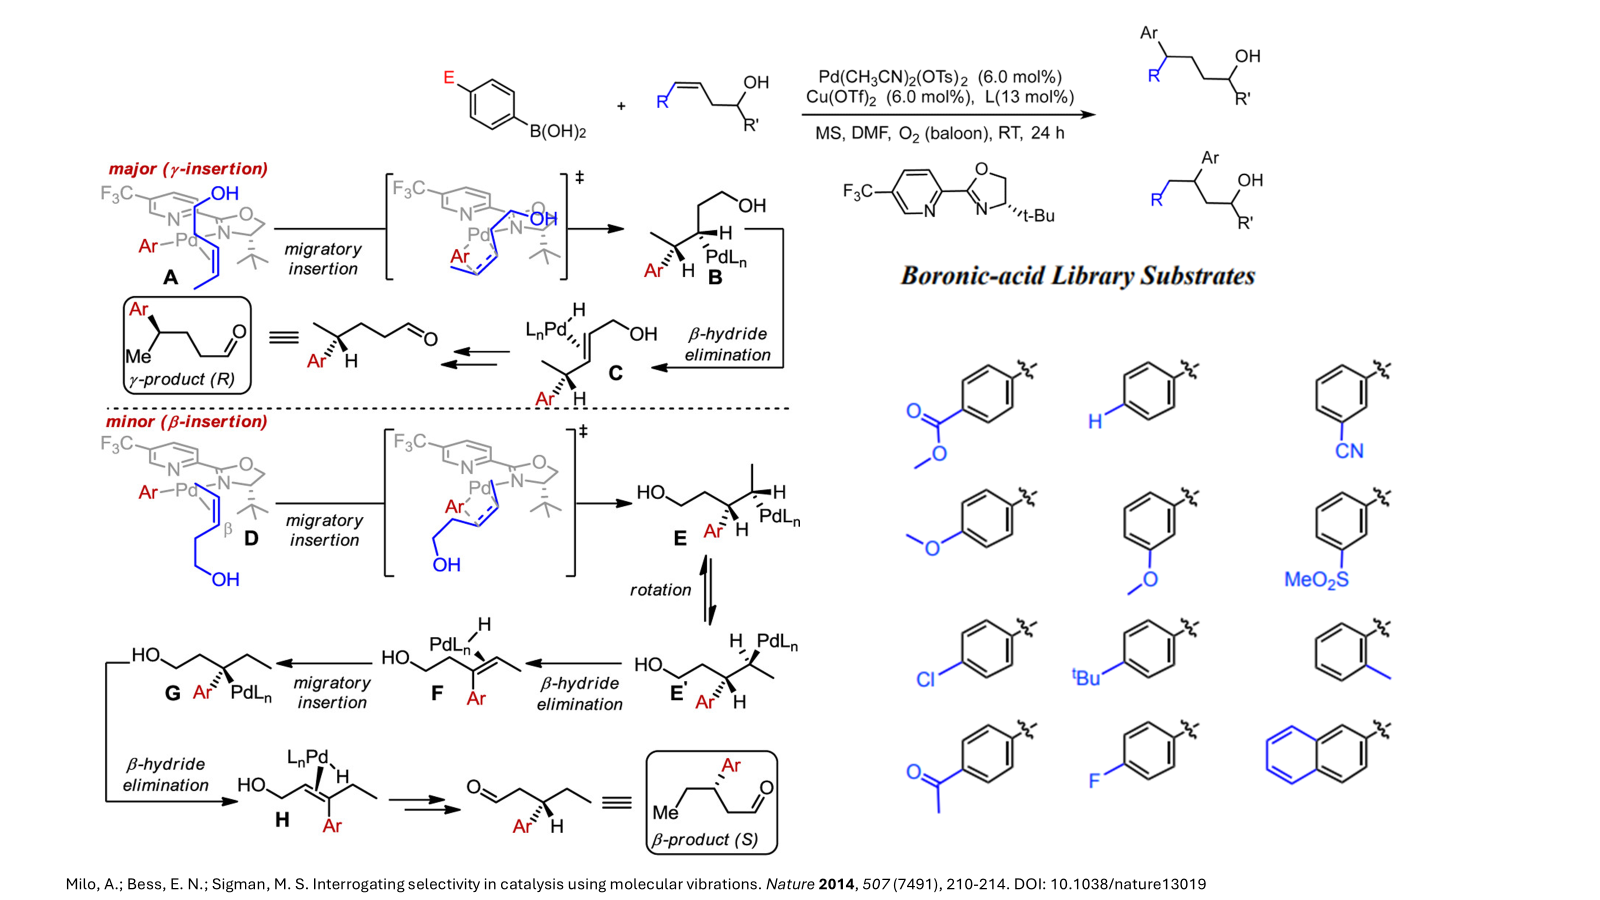

In [ ]:
## Benzoic example - output
ordered_measured_values = {
    "p-t-Bu_BA": 0.71,
    "p-OMe_BA": 0.44,
    "p-H_BA": 0.89,
    "p-F_BA": 1.18,
    "p-Cl_BA": 1.56,
    "p-COMe_BA": 1.64,
    "p-CO2Me_BA": 1.74,
    "o-Me_BA": 2.09,
    "naphthyl_BA": 2.01,
    "m-SO2Me_BA": 2.23,
    "m-OMe_BA": 0.96,
    "m-CN_BA": 2.30,
}

output_list = ordered_measured_values.values()

benzoic_mols= Molecules(r'/content/labcode_updated/MolFeatures/Getting_started_with_examples/study_cases/Benzoic_acids')

Molecules Loaded: ['m-SO2Me_BA.feather', 'p-CO2Me_BA.feather', 'p-t-Bu_BA.feather', 'p-F_BA.feather', 'p-OMe_BA.feather', 'naphthyl_BA.feather', 'p-Cl_BA.feather', 'm-OMe_BA.feather', 'm-CN_BA.feather', 'o-Me_BA.feather', 'p-COMe_BA.feather', 'p-H_BA.feather'] Failed Molecules: []


In [ ]:
# visualize the first molecule
benzoic_mols.visualize_molecules([0])

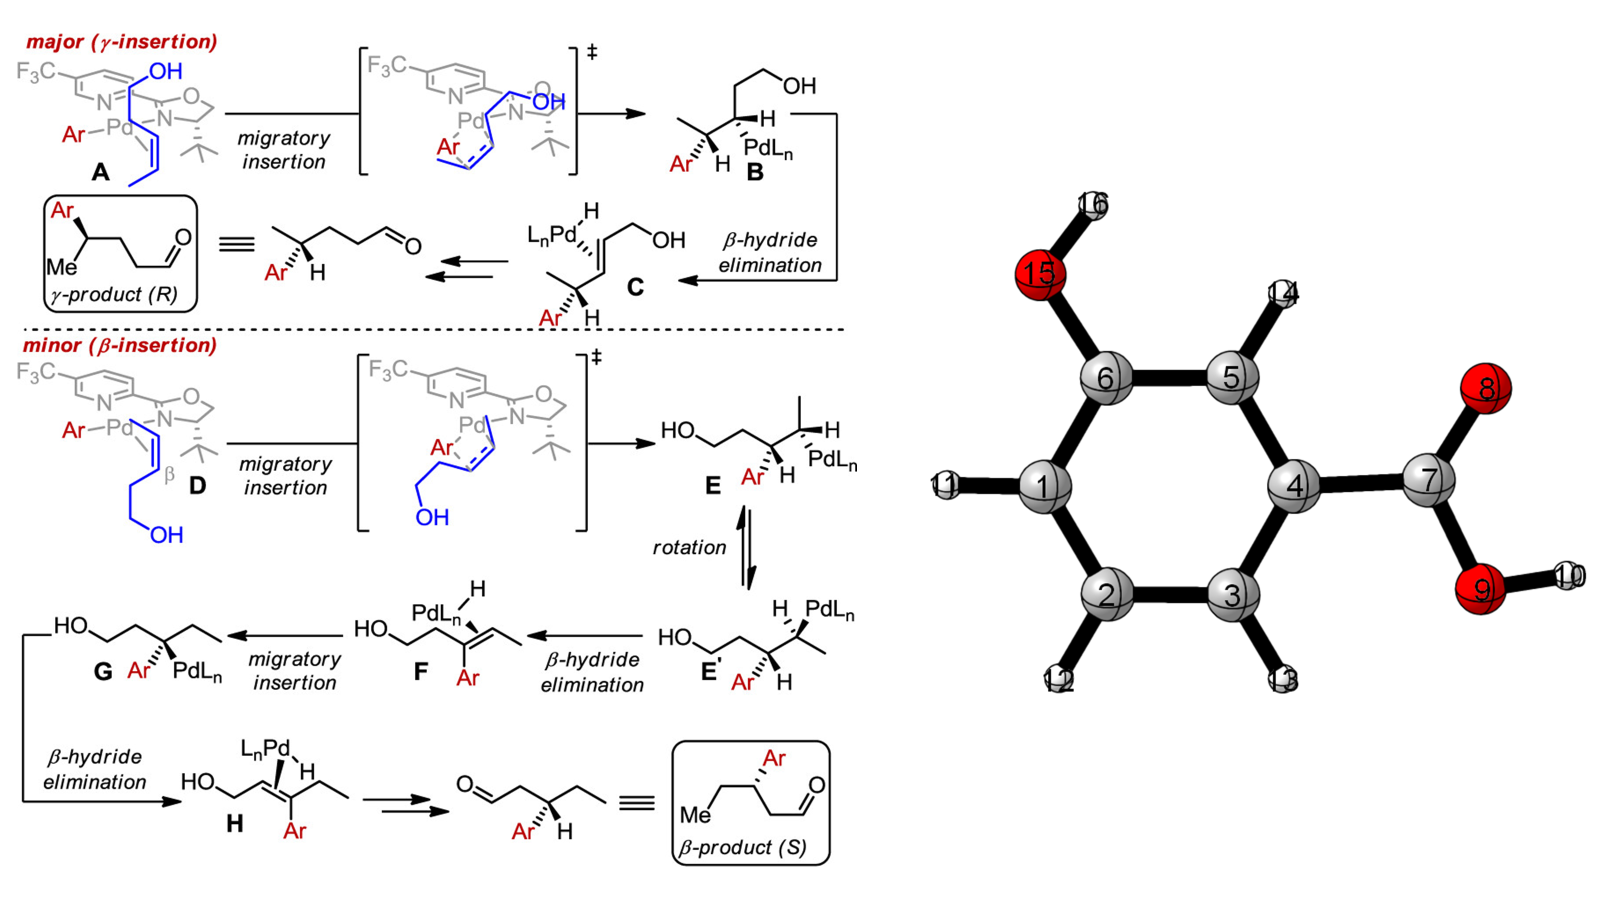

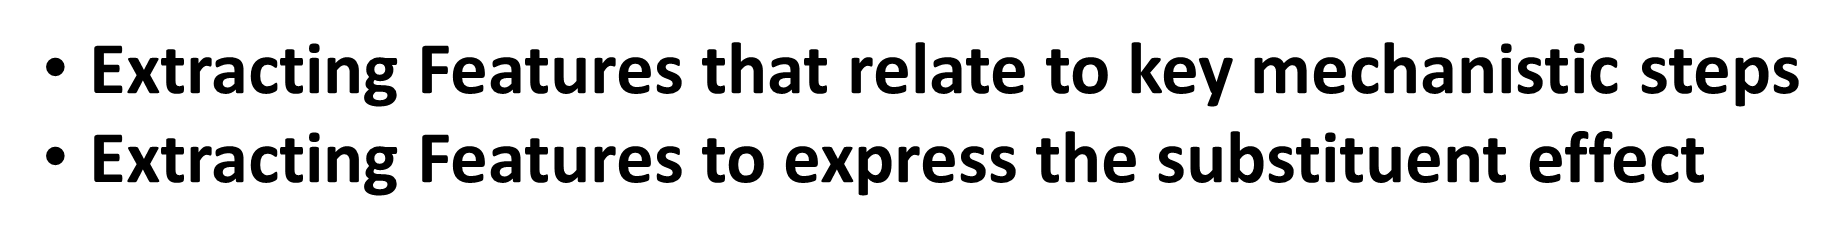


In [ ]:
## Benzoic Surrogate notebook
answers_dict = {
    "Ring Vibration atoms - by order -> Pick one  atom from a six member ring\n example: 13": [4],
    "Stretch Threshold": [1600],
    "Stretching Vibration atoms- enter bonded atom pairs: \n example: 1,2 4,5": [[7,8]],
    "Bend Threshold": [1400],
    "Bending Vibration atoms - enter atom pairs that have a common atom: \n example: 4,7": [],
    "Center_Atoms Dipole": [],
    "Dipole atoms - indices for coordination transformation: \n example: 4,5,6 - origin, y-axis, new xy plane": [[2,1,7]],
    "Sub-Atoms NPA": [] ,
    "NPA manipulation atoms - Insert atoms to show NPA: \n example: 1,2,4": [],
    "charges values - Insert atoms to show charge: \n example: 1,2,3,4": [7,1,8],
    "charge_diff - Insert atoms to show charge difference: \n example: 1,2 3,4": [],
    "Sterimol atoms - Primary axis along: \n example: 7,8": [[7,1]],
    'drop_atoms - Atoms to drop: \n example: 1,2,3': [],
    "Bond_length - Atom pairs to calculate difference: \n example: 1,2 4,5": [[9,10],[7,8]],
    'Bond_angle - Atom triplets to calculate difference: \n example: 1,2,3 4,5,6': [[1,7,8],[7,1,2,6]],
}
current_dir=os.getcwd()
json_path=os.path.join(current_dir,'Benzoic_features.json')
help_functions.save_input_json(answers_dict, json_path=json_path)
df=benzoic_mols.get_molecules_features_set(entry_widgets=answers_dict,answers_list=None, save_as=True,csv_file_name='Benzoic_features')
df['output']=output_list


Input saved to /content/labcode_updated/MolFeatures/Getting_started_with_examples/study_cases/Benzoic_features.json
Calculating stretch vibration for atoms [[7, 8]] with threshold 1600 
 Remember : ALWAYS LOOK AT THE RESULTING VIBRATION


interactive(children=(FloatSlider(value=0.9, description='Threshold', max=1.0, step=0.01), Output()), _dom_cla…

Features saved to Benzoic_features_20251019_095832.csv and correlation table to Benzoic_features_20251019_095832_correlation_table.csv in /content/labcode_updated/MolFeatures/Getting_started_with_examples/study_cases


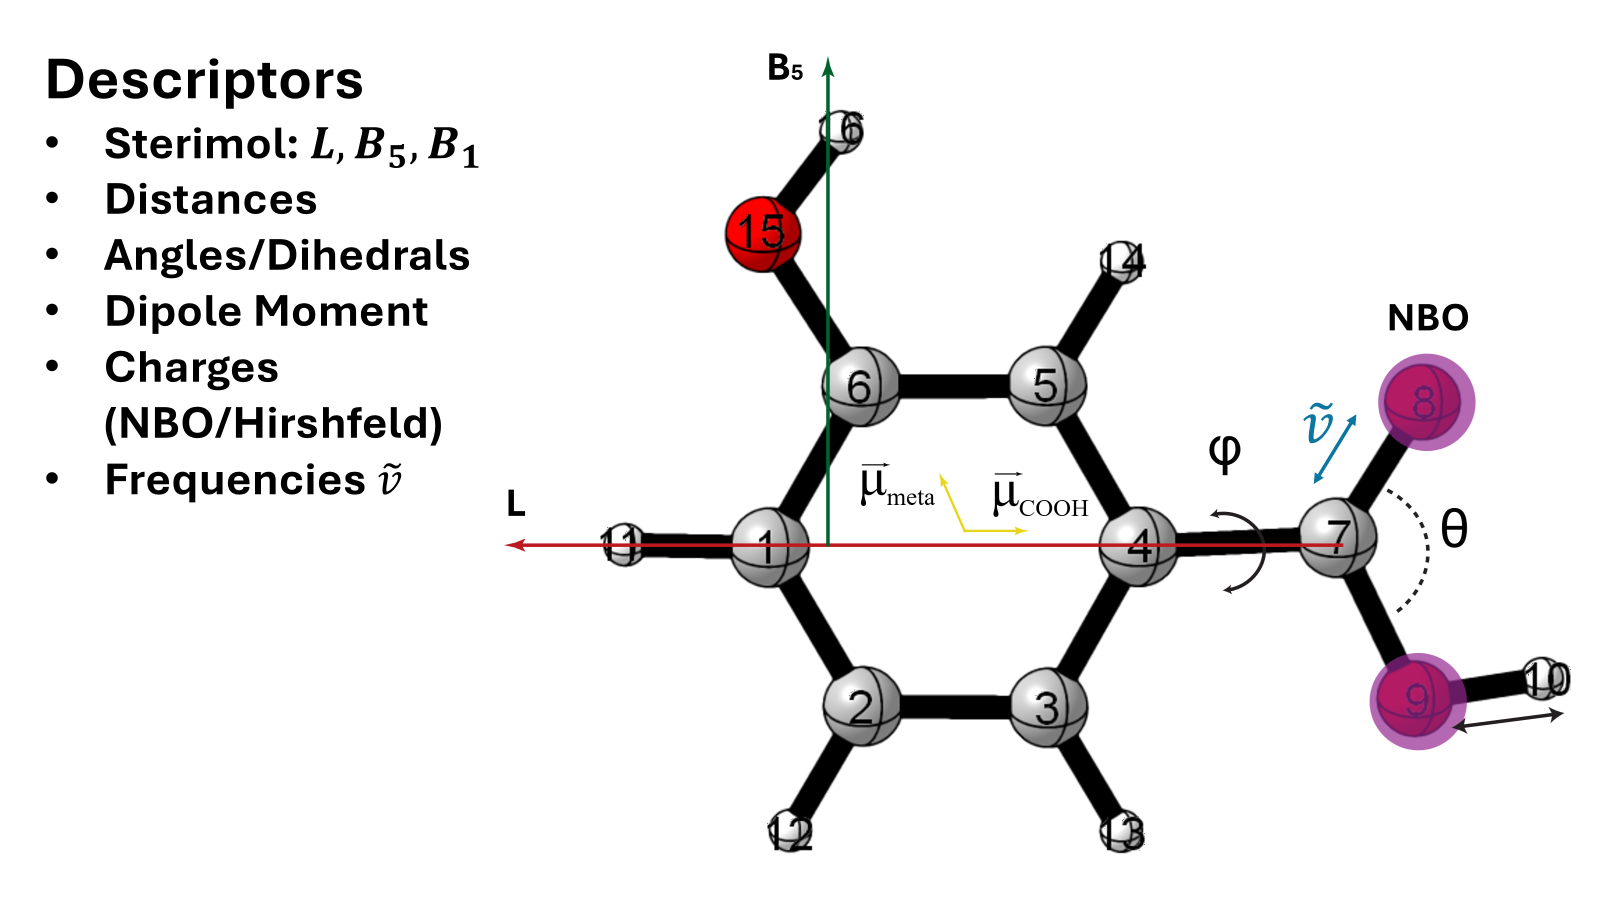

Creating new run directory: runs/in_memory_dataset_output_linear_20251019
Database does not exist. It will be created at: /content/labcode_updated/MolFeatures/Getting_started_with_examples/study_cases/runs/in_memory_dataset_output_linear_20251019/db/results_in_memory_dataset.db
Table 'regression_results' has been ensured to exist.
linear model selected
Processed DataFrame
Names column: <index> | Target: output
Rows: 12 | Features: 30 â 30
--- Correlation Report ---
Features with |r| > 0.8:
['Amplitude_Stretch_7_8', 'B1_7-1', 'B1_B5_angle_7-1', 'Frequency_Stretch_7_8', 'angle_[1, 7, 8]', 'bond_length_7-8', 'bond_length_9-10', 'cm5_atom_1', 'cm5_atom_7', 'cm5_atom_8', 'cross_angle', 'dihedral_[7, 1, 2, 6]', 'hirshfeld_atom_1', 'hirshfeld_atom_7', 'hirshfeld_atom_8', 'nbo_atom_1', 'nbo_atom_7', 'nbo_atom_8', 'para_angle']
VIF pruning skipped by user/preference.
Using 1 jobs for evaluation. Found 2 cores.
Loaded 0 existing results from DB.
Combos to run: 435, done_combos: 0
Evaluating 43

Threshold 0.750 (single-core):  16%|█▌        | 68/435 [00:01<00:06, 59.38it/s]

R2:0.796 Q2: 0.671, MAE: 0.300, RMSD: 0.346 for combination: ('para', 'nbo_atom_8')
R2:0.821 Q2: 0.729, MAE: 0.263, RMSD: 0.314 for combination: ('para', 'hirshfeld_atom_1')
R2:0.837 Q2: 0.724, MAE: 0.291, RMSD: 0.317 for combination: ('para', 'cm5_atom_7')
R2:0.812 Q2: 0.714, MAE: 0.277, RMSD: 0.323 for combination: ('para', 'cm5_atom_1')
R2:0.774 Q2: 0.449, MAE: 0.372, RMSD: 0.448 for combination: ('para', 'cm5_atom_8')


Threshold 0.750 (single-core):  37%|███▋      | 162/435 [00:02<00:05, 52.31it/s]

R2:0.811 Q2: -6.598, MAE: 0.735, RMSD: 1.663 for combination: ('dipole_x_2-1-7', 'dipole_z_2-1-7')
R2:0.884 Q2: 0.842, MAE: 0.176, RMSD: 0.240 for combination: ('dipole_x_2-1-7', 'total_dipole_2-1-7')
R2:0.758 Q2: 0.526, MAE: 0.365, RMSD: 0.415 for combination: ('dipole_x_2-1-7', 'hirshfeld_atom_7')


Threshold 0.750 (single-core):  40%|███▉      | 173/435 [00:03<00:06, 40.37it/s]

R2:0.788 Q2: 0.609, MAE: 0.318, RMSD: 0.377 for combination: ('dipole_x_2-1-7', 'hirshfeld_atom_8')
R2:0.770 Q2: 0.517, MAE: 0.361, RMSD: 0.420 for combination: ('dipole_x_2-1-7', 'cm5_atom_8')
R2:0.869 Q2: 0.785, MAE: 0.219, RMSD: 0.280 for combination: ('dipole_x_2-1-7', 'B5_7-1')


Threshold 0.750 (single-core):  99%|█████████▉| 432/435 [00:07<00:00, 66.44it/s]

R2:0.796 Q2: 0.634, MAE: 0.319, RMSD: 0.365 for combination: ('angle_[1, 7, 8]', 'dihedral_[7, 1, 2, 6]')


Threshold 0.750 (single-core): 100%|██████████| 435/435 [00:07<00:00, 59.91it/s]
/content/labcode_updated/MolFeatures/M3_modeler/plot.py:366: UserWarning:

The figure layout has changed to tight



[PDF] Skipping top-5 export due to error: 'LinearRegressionModel' object has no attribute 'molecules_names'
| formula                                      |     R.sq |        Q.sq |        MAE |   Model_id |
|:---------------------------------------------|---------:|------------:|-----------:|-----------:|
| ('dipole_x_2-1-7', 'total_dipole_2-1-7')     | 0.884484 |    0.841857 |   0.175874 |          0 |
| ('dipole_x_2-1-7', 'B5_7-1')                 | 0.868918 |    0.78524  |   0.219447 |          1 |
| ('para', 'hirshfeld_atom_1')                 | 0.821101 |    0.728526 |   0.263261 |          2 |
| ('para', 'cm5_atom_7')                       | 0.83736  |    0.723644 |   0.290628 |          3 |
| ('para', 'cm5_atom_1')                       | 0.811677 |    0.714133 |   0.276811 |          4 |
| ('para', 'nbo_atom_8')                       | 0.796158 |    0.670948 |   0.299519 |          5 |
| ('angle_[1, 7, 8]', 'dihedral_[7, 1, 2, 6]') | 0.796193 |    0.633642 |   0.318996 |      

/content/labcode_updated/MolFeatures/M3_modeler/plot.py:366: UserWarning:

The figure layout has changed to tight



Do you want to select another model? (y/n): n
Exiting model selection.


,id,combination,r2,q2,mae,rmsd,threshold,model,predictions
161,NaN,"('dipole_x_2-1-7', 'total_dipole_2-1-7')",0.884484,0.841857,0.175874,0.239993,0.75,<modeling.LinearRegressionModel object at 0x7a...,"[0.6458758715740878, 0.38975248462435763, 0.85..."
172,NaN,"('dipole_x_2-1-7', 'B5_7-1')",0.868918,0.785240,0.219447,0.279673,0.75,<modeling.LinearRegressionModel object at 0x7a...,"[0.7326118293278496, 0.32664135313867115, 0.93..."
68,NaN,"('para', 'hirshfeld_atom_1')",0.821101,0.728526,0.263261,0.314441,0.75,<modeling.LinearRegressionModel object at 0x7a...,"[0.8395125857410335, 0.29573775109484046, 1.35..."
70,NaN,"('para', 'cm5_atom_7')",0.837360,0.723644,0.290628,0.317255,0.75,<modeling.LinearRegressionModel object at 0x7a...,"[0.8058813969820688, 0.31910211260816634, 1.23..."
71,NaN,"('para', 'cm5_atom_1')",0.811677,0.714133,0.276811,0.322669,0.75,<modeling.LinearRegressionModel object at 0x7a...,"[0.8487368033677001, 0.3140632970889641, 1.334..."
66,NaN,"('para', 'nbo_atom_8')",0.796158,0.670948,0.299519,0.346184,0.75,<modeling.LinearRegressionModel object at 0x7a...,"[0.8386945345681909, 0.5637953898412604, 1.312..."
420,NaN,"('angle_[1, 7, 8]', 'dihedral_[7, 1, 2, 6]')",0.796193,0.633642,0.318996,0.365281,0.75,<modeling.LinearRegressionModel object at 0x7a...,"[0.8517683945098042, 0.6803069010683203, 0.998..."
167,NaN,"('dipole_x_2-1-7', 'hirshfeld_atom_8')",0.787979,0.609355,0.317776,0.377195,0.75,<modeling.LinearRegressionModel object at 0x7a...,"[0.736749627658547, 0.290136664822505, 1.05482..."
165,NaN,"('dipole_x_2-1-7', 'hirshfeld_atom_7')",0.758365,0.526262,0.365405,0.415378,0.75,<modeling.LinearRegressionModel object at 0x7a...,"[0.8234537959772616, 0.18587768657198467, 1.18..."
170,NaN,"('dipole_x_2-1-7', 'cm5_atom_8')",0.769973,0.516548,0.361025,0.419615,0.75,<modeling.LinearRegressionModel object at 0x7a...,"[0.7446381229454051, 0.2838399545278616, 1.066..."


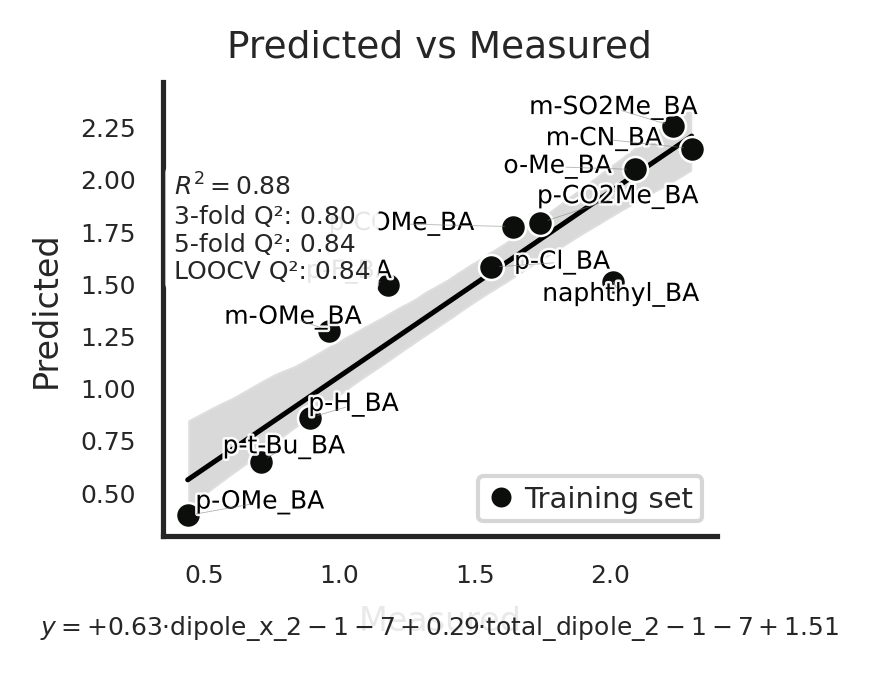

In [ ]:
regression_model_benzoic = LinearRegressionModel(df, process_method='one csv', y_value='output',
                                        leave_out=None, min_features_num=2, max_features_num=2, metrics=None, return_coefficients=False)
regression_model_benzoic.search_models(threshold = 0.75)

**Benzaldehyde Seondary Sphere - Study Case**

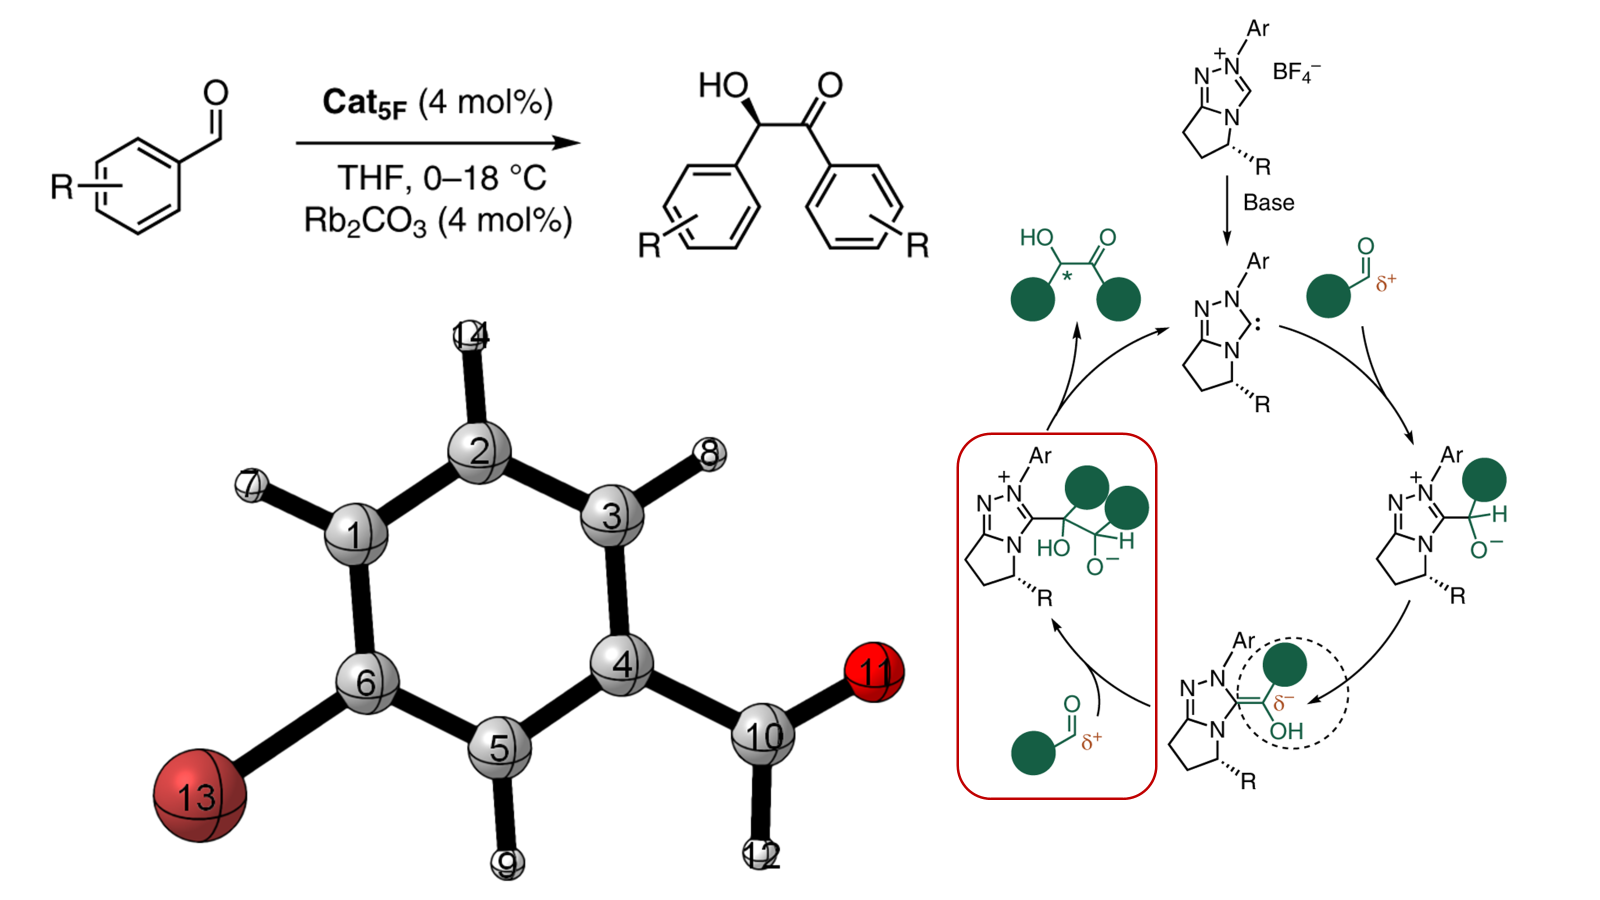

In [ ]:

output_by_name = {
    "NO2-3": 1.13,   # 3-NO2
    "I-4": 2.27,     # 4-I
    "I-3": 1.60,     # 3-I
    "F-4": 2.27,     # 4-F
    "F-3": 2.27,     # 3-F
    "Cl-m": 1.51,    # 3,5-Cl
    "Cl-4": 2.27,    # 4-Cl
    "Cl-3": 2.13,    # 3-Cl
    "COOMe-4": 2.08, # 4-COOMe
    "COOMe-3": 1.63, # 3-COOMe
    "CN-4": 1.55,    # 4-CN
    "CF3-4": 2.13,   # 4-CF3
    "CF3-3": 1.22,   # 3-CF3
    "Br-m": 1.26,    # 3,5-Br
    "Br-4": 2.44,    # 4-Br
    "Br-3": 1.85,               # 3-Br
}

output_list = output_by_name.values()


sphere_mols= Molecules(r'/content/labcode_updated/MolFeatures/Getting_started_with_examples/study_cases/Benzoaldehydes/feathers')

Molecules Loaded: ['Br-3.feather', 'Cl-m.feather', 'I-4.feather', 'COOMe-3.feather', 'NO2-3.feather', 'Cl-3.feather', 'COOMe-4.feather', 'I-3.feather', 'CF3-4.feather', 'Br-4.feather', 'Br-m.feather', 'F-4.feather', 'CF3-3.feather', 'F-3.feather', 'CN-4.feather', 'Cl-4.feather'] Failed Molecules: []


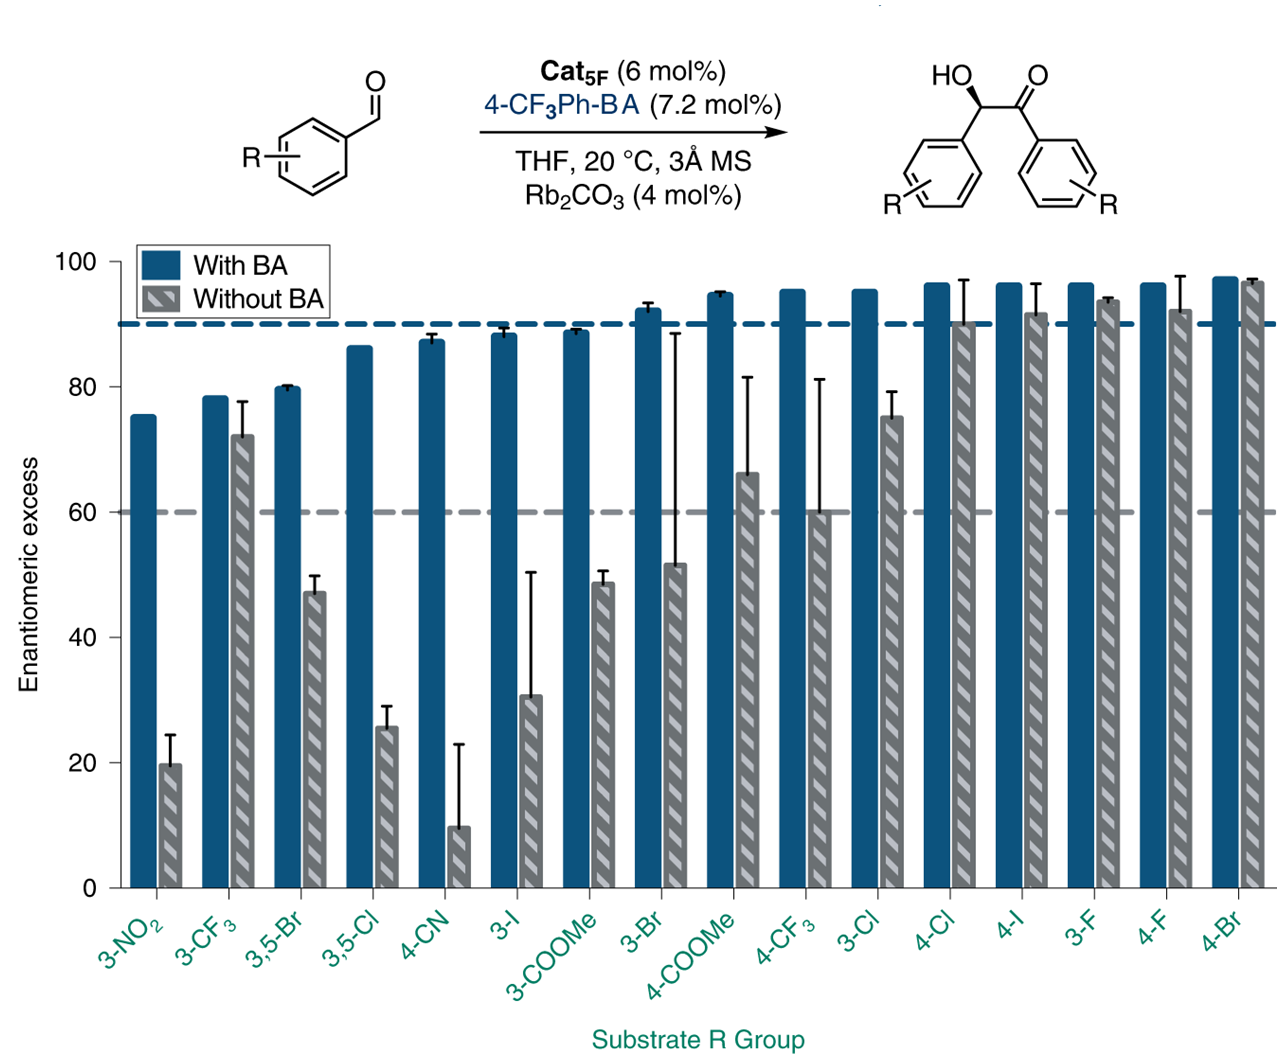

In [ ]:
## Secondary sphere notebook
answers_dict = {
    "Ring Vibration atoms - by order -> Pick one  atom from a six member ring\n example: 13": [4],
    "Stretch Threshold": [1600],
    "Stretching Vibration atoms- enter bonded atom pairs: \n example: 1,2 4,5": [[10,11]],
    "Bend Threshold": [1400],
    "Bending Vibration atoms - enter atom pairs that have a common atom: \n example: 4,7": [],
    "Center_Atoms Dipole": [],
    "Dipole atoms - indices for coordination transformation: \n example: 4,5,6 - origin, y-axis, new xy plane": [[10,4,3]],
    "Sub-Atoms NPA": [] ,
    "NPA manipulation atoms - Insert atoms to show NPA: \n example: 1,2,4": [],
    "charges values - Insert atoms to show charge: \n example: 1,2,3,4": [4,10],
    "charge_diff - Insert atoms to show charge difference: \n example: 1,2 3,4": [],
    "Sterimol atoms - Primary axis along: \n example: 7,8": [[10,4]],
    'drop_atoms - Atoms to drop: \n example: 1,2,3': [],
    "Bond_length - Atom pairs to calculate difference: \n example: 1,2 4,5": [[4,10],[10,11]],
    'Bond_angle - Atom triplets to calculate difference: \n example: 1,2,3 4,5,6': [[12,10,11],[12,10,11,4]],
}
current_dir=os.getcwd()
json_path=os.path.join(current_dir,'second_sphere_input.json')
help_functions.save_input_json(answers_dict, json_path=json_path)
df=sphere_mols.get_molecules_features_set(entry_widgets=answers_dict,answers_list=None, save_as=True,csv_file_name='features_second_sphere')
df['output']=output_list
print(df.head())

In [ ]:
## Secondary sphere notebook
answers_dict = {
    "Ring Vibration atoms - by order -> Pick one  atom from a six member ring\n example: 13": [4],
    "Stretch Threshold": [1600],
    "Stretching Vibration atoms- enter bonded atom pairs: \n example: 1,2 4,5": [[10,11]],
    "Bend Threshold": [1400],
    "Bending Vibration atoms - enter atom pairs that have a common atom: \n example: 4,7": [],
    "Center_Atoms Dipole": [],
    "Dipole atoms - indices for coordination transformation: \n example: 4,5,6 - origin, y-axis, new xy plane": [[10,4,3]],
    "Sub-Atoms NPA": [] ,
    "NPA manipulation atoms - Insert atoms to show NPA: \n example: 1,2,4": [],
    "charges values - Insert atoms to show charge: \n example: 1,2,3,4": [4,10],
    "charge_diff - Insert atoms to show charge difference: \n example: 1,2 3,4": [],
    "Sterimol atoms - Primary axis along: \n example: 7,8": [[10,4]],
    'drop_atoms - Atoms to drop: \n example: 1,2,3': [],
    "Bond_length - Atom pairs to calculate difference: \n example: 1,2 4,5": [[4,10],[10,11]],
    'Bond_angle - Atom triplets to calculate difference: \n example: 1,2,3 4,5,6': [[12,10,11],[12,10,11,4]],
}
current_dir=os.getcwd()
json_path=os.path.join(current_dir,'second_sphere_input.json')
help_functions.save_input_json(answers_dict, json_path=json_path)
df=sphere_mols.get_molecules_features_set(entry_widgets=answers_dict,answers_list=None, save_as=True,csv_file_name='features_second_sphere')
df['output']=output_list
print(df.head())

Input saved to /content/labcode_updated/MolFeatures/Getting_started_with_examples/study_cases/Benzoaldehydes/second_sphere_input.json
Calculating stretch vibration for atoms [[10, 11]] with threshold 1600 
 Remember : ALWAYS LOOK AT THE RESULTING VIBRATION


interactive(children=(FloatSlider(value=0.9, description='Threshold', max=1.0, step=0.01), Output()), _dom_cla…

Features saved to features_second_sphere_20251019_101820.csv and correlation table to features_second_sphere_20251019_101820_correlation_table.csv in /content/labcode_updated/MolFeatures/Getting_started_with_examples/study_cases/Benzoaldehydes
           cross  cross_angle       para  para_angle  Frequency_Stretch_10_11  \
NO2-3  1714.7642    21.637869  1656.5418   79.810419                1850.6057   
I-4    1641.8462    40.523461  1659.0566   50.274172                1842.1913   
I-3    1643.0434    28.570518  1661.6286   62.977640                1844.8077   
F-4    1669.0566    41.925293  1679.3198   48.340299                1840.2009   
F-3    1672.1278    40.034830  1683.1186   53.070050                1846.2097   

       Amplitude_Stretch_10_11  dipole_x_10-4-3  dipole_y_10-4-3  \
NO2-3                 1.474911         2.156273         0.230606   
I-4                   0.620274        -1.780430         1.334175   
I-3                   1.473483        -0.519384         1.911728 

Creating new run directory: runs/in_memory_dataset_output_linear_20251019
Database does not exist. It will be created at: /content/labcode_updated/MolFeatures/Getting_started_with_examples/study_cases/Benzoaldehydes/runs/in_memory_dataset_output_linear_20251019/db/results_in_memory_dataset.db
Table 'regression_results' has been ensured to exist.
linear model selected
Processed DataFrame
Names column: <index> | Target: output
Rows: 16 | Features: 27 â 27
--- Correlation Report ---
Features with |r| > 0.8:
['Frequency_Stretch_10_11', 'angle_[12, 10, 11]', 'bond_length_10-11', 'bond_length_4-10', 'cm5_atom_10', 'cm5_atom_4', 'cross_angle', 'hirshfeld_atom_10', 'hirshfeld_atom_4', 'nbo_atom_4', 'para_angle']
VIF pruning skipped by user/preference.
Using 1 jobs for evaluation. Found 2 cores.
Loaded 0 existing results from DB.
Combos to run: 351, done_combos: 0
Evaluating 351 new combos with R2 >= 0.800...


Threshold 0.800 (single-core):  97%|█████████▋| 340/351 [00:05<00:00, 66.04it/s]

R2:0.847 Q2: 0.759, MAE: 0.173, RMSD: 0.207 for combination: ('B1_B5_angle_10-4', 'angle_[12, 10, 11]')


Threshold 0.800 (single-core): 100%|██████████| 351/351 [00:05<00:00, 64.32it/s]
/content/labcode_updated/MolFeatures/M3_modeler/plot.py:366: UserWarning:

The figure layout has changed to tight



[PDF] Skipping top-5 export due to error: 'LinearRegressionModel' object has no attribute 'molecules_names'
| formula                                           |     R.sq |        Q.sq |        MAE |   Model_id |
|:--------------------------------------------------|---------:|------------:|-----------:|-----------:|
| ('B1_B5_angle_10-4', 'angle_[12, 10, 11]')        | 0.846823 |    0.759136 |   0.172956 |          0 |
| ('B5_10-4', 'angle_[12, 10, 11]')                 | 0.798552 | -inf        | inf        |          1 |
| ('nbo_atom_4', 'hirshfeld_atom_10')               | 0.796548 | -inf        | inf        |          2 |
| ('dipole_x_10-4-3', 'angle_[12, 10, 11]')         | 0.793306 | -inf        | inf        |          3 |
| ('nbo_atom_4', 'cm5_atom_10')                     | 0.790503 | -inf        | inf        |          4 |
| ('nbo_atom_4', 'angle_[12, 10, 11]')              | 0.787485 | -inf        | inf        |          5 |
| ('cross', 'angle_[12, 10, 11]')                   

/content/labcode_updated/MolFeatures/M3_modeler/plot.py:366: UserWarning:

The figure layout has changed to tight



Do you want to select another model? (y/n): n
Exiting model selection.


,id,combination,r2,q2,mae,rmsd,threshold,model,predictions
330,NaN,"('B1_B5_angle_10-4', 'angle_[12, 10, 11]')",0.846823,0.759136,0.172956,0.206889,0.8,<modeling.LinearRegressionModel object at 0x7a...,"[1.346057016877694, 2.285301727603951, 1.95455..."
309,NaN,"('B5_10-4', 'angle_[12, 10, 11]')",0.798552,-inf,inf,inf,0.8,<modeling.LinearRegressionModel object at 0x7a...,"[1.1953754842485864, 2.255471996594167, 1.9867..."
217,NaN,"('nbo_atom_4', 'hirshfeld_atom_10')",0.796548,-inf,inf,inf,0.8,<modeling.LinearRegressionModel object at 0x7a...,"[0.9892874741961606, 2.175222134669646, 1.9233..."
155,NaN,"('dipole_x_10-4-3', 'angle_[12, 10, 11]')",0.793306,-inf,inf,inf,0.8,<modeling.LinearRegressionModel object at 0x7a...,"[0.9957885418660339, 2.3005827787181943, 1.862..."
219,NaN,"('nbo_atom_4', 'cm5_atom_10')",0.790503,-inf,inf,inf,0.8,<modeling.LinearRegressionModel object at 0x7a...,"[0.9818370866072641, 2.1745393967373587, 1.929..."
225,NaN,"('nbo_atom_4', 'angle_[12, 10, 11]')",0.787485,-inf,inf,inf,0.8,<modeling.LinearRegressionModel object at 0x7a...,"[1.0376607480703797, 2.2228467437454356, 1.931..."
20,NaN,"('cross', 'angle_[12, 10, 11]')",0.778556,-inf,inf,inf,0.8,<modeling.LinearRegressionModel object at 0x7a...,"[1.0164061362357302, 2.3002051898214404, 1.956..."
338,NaN,"('angle_[12, 10, 11]', 'bond_length_10-11')",0.776933,-inf,inf,inf,0.8,<modeling.LinearRegressionModel object at 0x7a...,"[1.1442309676994, 2.26323763314997, 1.90468338..."
340,NaN,"('angle_[12, 10, 11]', 'iso')",0.774145,-inf,inf,inf,0.8,<modeling.LinearRegressionModel object at 0x7a...,"[1.2140471753162956, 2.3038795619878556, 1.933..."
263,NaN,"('hirshfeld_atom_10', 'B5_10-4')",0.769428,-inf,inf,inf,0.8,<modeling.LinearRegressionModel object at 0x7a...,"[1.3043786358486713, 2.240814374022028, 1.9993..."


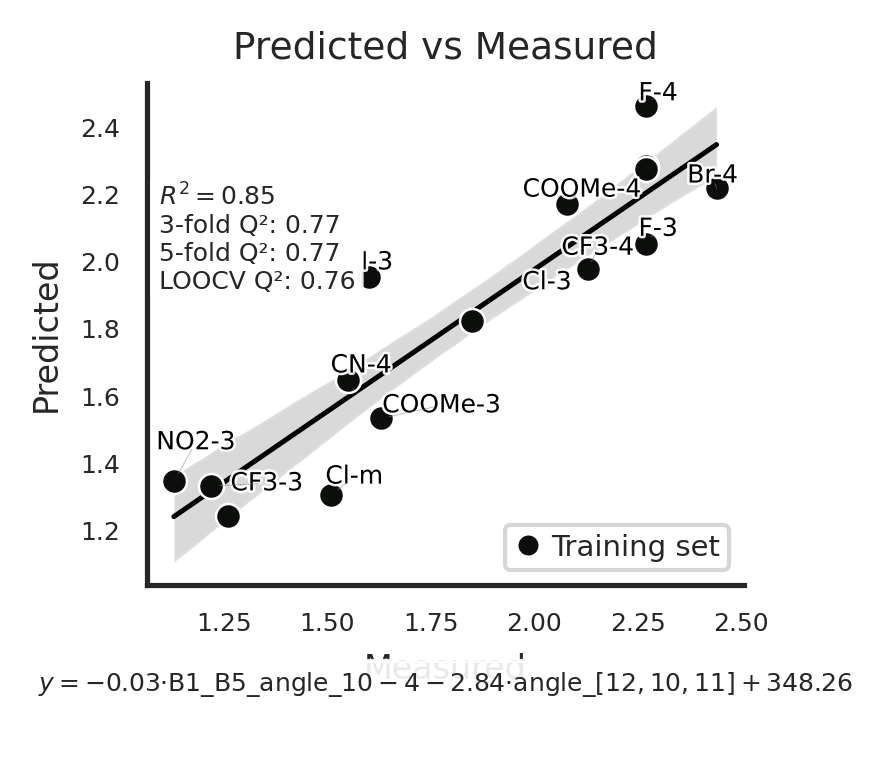

In [ ]:
regression_model_benzaldehyde = LinearRegressionModel(df, process_method='one csv', y_value='output',
                                        leave_out=None, min_features_num=2, max_features_num=2, metrics=None, return_coefficients=False)
regression_model_benzaldehyde.search_models(threshold = 0.8)

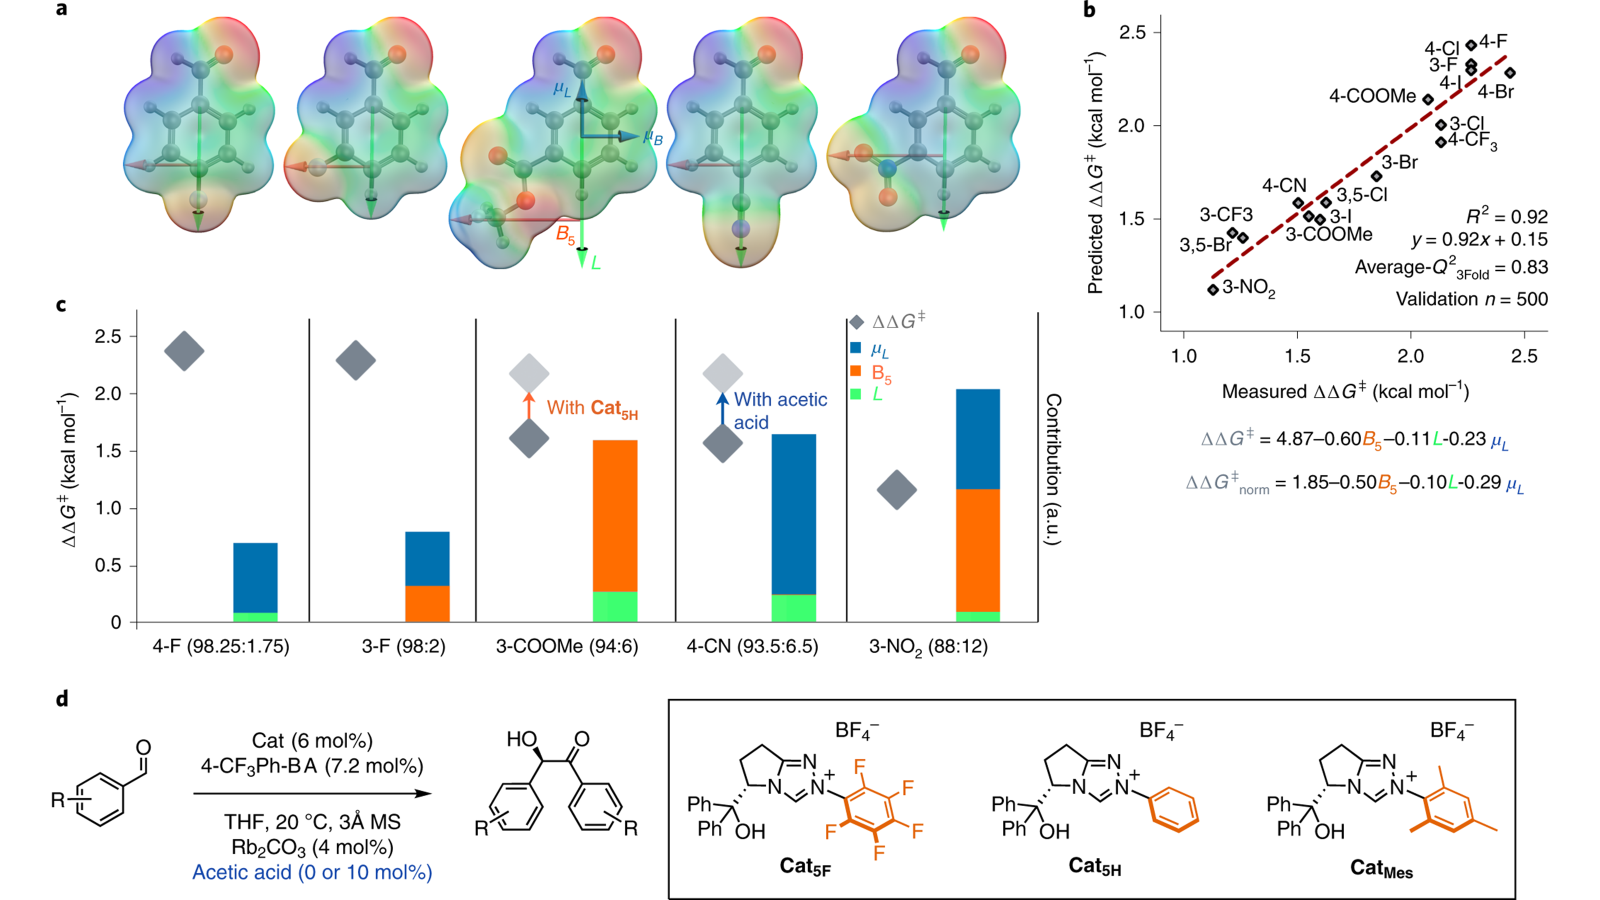